 **DATASET ANALYSIS AND PREPROCESSING**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
df = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')

In [5]:
print("Initial Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print("Unique Medical Specialties:", df['medical_specialty'].nunique())
print("Specialty Distribution:\n", df['medical_specialty'].value_counts())

Initial Dataset Shape: (4999, 6)
   Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white

Handling Missing Values

In [6]:
print("\nMissing Values:\n", df.isnull().sum())
df = df.dropna(subset=['transcription'])
df['keywords'].fillna('', inplace=True)
df['description'].fillna('', inplace=True)


Missing Values:
 Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


/tmp/ipython-input-1881398433.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keywords'].fillna('', inplace=True)
/tmp/ipython-input-1881398433.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [7]:
print("\nDuplicates:", df.duplicated().sum())
df = df.drop_duplicates()


Duplicates: 0


Text Cleaning

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [9]:
df['cleaned_transcription'] = df['transcription'].apply(clean_text)
df['cleaned_keywords'] = df['keywords'].apply(clean_text)
df['cleaned_description'] = df['description'].apply(clean_text)

In [10]:
print("\nSample Cleaned Transcription:\n", df['cleaned_transcription'].iloc[0])
df['features'] = df['cleaned_transcription'] + ' ' + df['cleaned_keywords']


Sample Cleaned Transcription:
 subjective yearold white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used last summer began using two weeks ago appear working well used overthecounter sprays prescription nasal sprays asthma doest require daily medication think flaring upmedications medication currently ortho tricyclen allegraallergies known medicine allergiesobjectivevitals weight pounds blood pressure heent throat mildly erythematous without exudate nasal mucosa erythematous swollen clear drainage seen tms clearneck supple without adenopathylungs clearassessment allergic rhinitisplan try zyrtec instead allegra another option use loratadine think prescription coverage might cheaper samples nasonex two sprays nostril given three weeks prescription written well


Splitting data into train, test and validation sets

In [11]:
X = df['features']
y = df['medical_specialty']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTrain Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Train Specialty Distribution:\n", y_train.value_counts(normalize=True))


Train Shape: (3972,) (3972,)
Validation Shape: (994,) (994,)
Train Specialty Distribution:
 medical_specialty
Surgery                          0.219033
Consult - History and Phy.       0.103978
Cardiovascular / Pulmonary       0.074773
Orthopedic                       0.071501
Radiology                        0.054884
General Medicine                 0.052115
Gastroenterology                 0.045065
Neurology                        0.044814
SOAP / Chart / Progress Notes    0.033484
Urology                          0.031470
Obstetrics / Gynecology          0.031219
Discharge Summary                0.021652
ENT - Otolaryngology             0.019386
Neurosurgery                     0.018882
Hematology - Oncology            0.018127
Ophthalmology                    0.016616
Nephrology                       0.016365
Emergency Room Reports           0.015106
Pediatrics - Neonatal            0.014099
Pain Management                  0.012336
Psychiatry / Psychology          0.010574
Office 

In [12]:
df.to_csv('processed_mtsamples.csv', index=False)

**EDA ON PREPROCESSED DATA**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

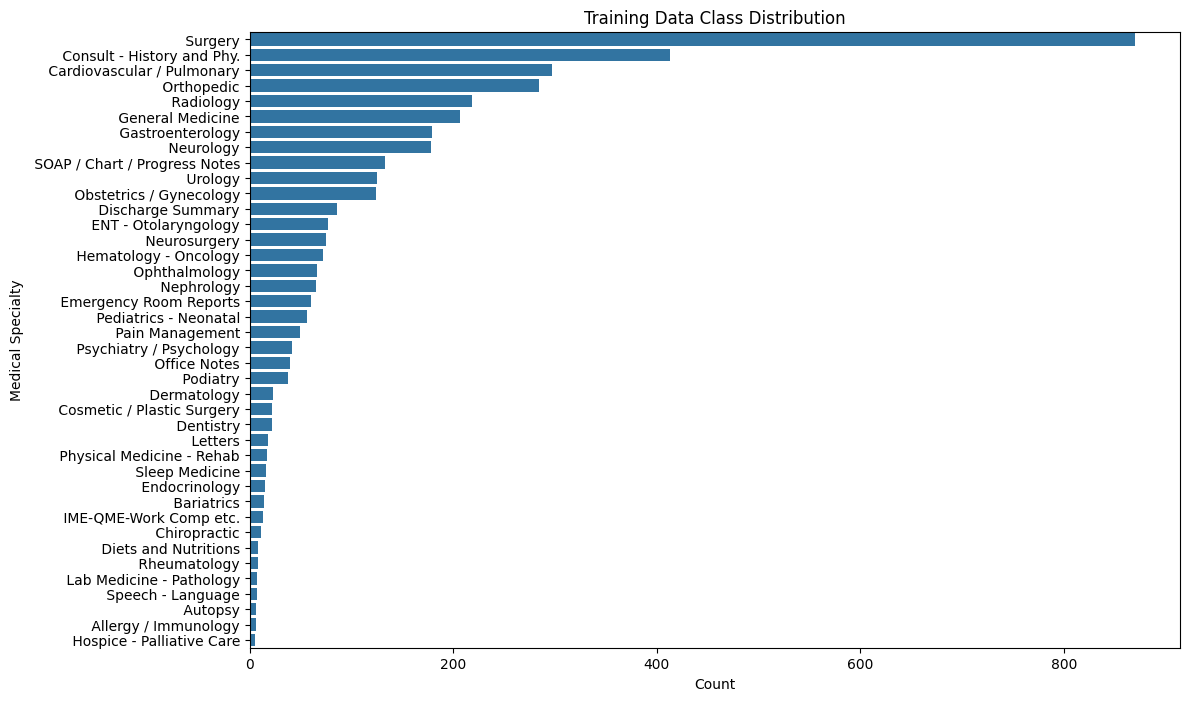

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(y=y_train, order=y_train.value_counts().index)
plt.title('Training Data Class Distribution')
plt.xlabel('Count')
plt.ylabel('Medical Specialty')
plt.show()

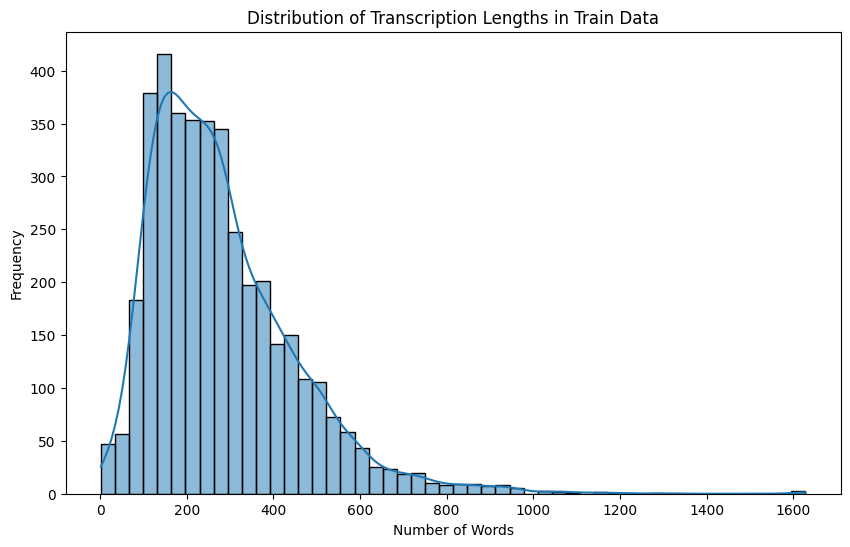

In [15]:
train_lengths = X_train.apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, bins=50, kde=True)
plt.title('Distribution of Transcription Lengths in Train Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

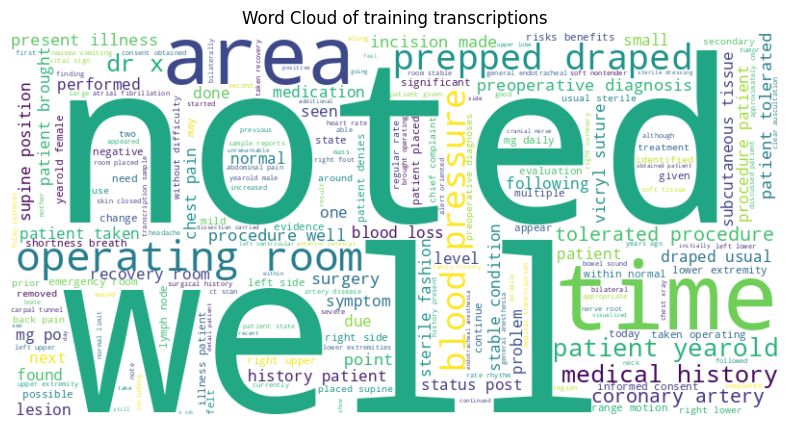

In [16]:
all_text = ' '.join(X_train)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of training transcriptions')
plt.show()

In [17]:
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(X_train)
top_words = pd.DataFrame(word_counts.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False).head(20)
print("Top 20 words in train data:\n", top_words)

Top 20 words in train data:
                0
patient    17806
right       9034
left        8664
history     6893
placed      5645
normal      5413
pain        4594
procedure   4039
mg          3424
using       3301
blood       3173
time        3167
noted       3142
performed   3141
incision    3058
removed     3002
skin        2843
used        2777
room        2768
artery      2640


**TRAINING BASELINE MODEL**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [20]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
clf.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [21]:
y_pred = clf.predict(X_val_tfidf)

In [22]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Baseline Accuracy: {accuracy:.4f}")
print(f"Baseline Macro F1: {f1:.4f}")
print(classification_report(y_val, y_pred))

Baseline Accuracy: 0.4105
Baseline Macro F1: 0.4511
                                precision    recall  f1-score   support

          Allergy / Immunology       0.17      1.00      0.29         1
                       Autopsy       1.00      1.00      1.00         2
                    Bariatrics       0.40      0.50      0.44         4
    Cardiovascular / Pulmonary       0.49      0.58      0.53        74
                  Chiropractic       0.10      0.33      0.15         3
    Consult - History and Phy.       0.34      0.12      0.17       103
    Cosmetic / Plastic Surgery       0.27      0.80      0.40         5
                     Dentistry       0.44      0.80      0.57         5
                   Dermatology       0.40      0.33      0.36         6
          Diets and Nutritions       0.33      1.00      0.50         2
             Discharge Summary       0.58      0.50      0.54        22
          ENT - Otolaryngology       0.44      0.79      0.57        19
        Eme

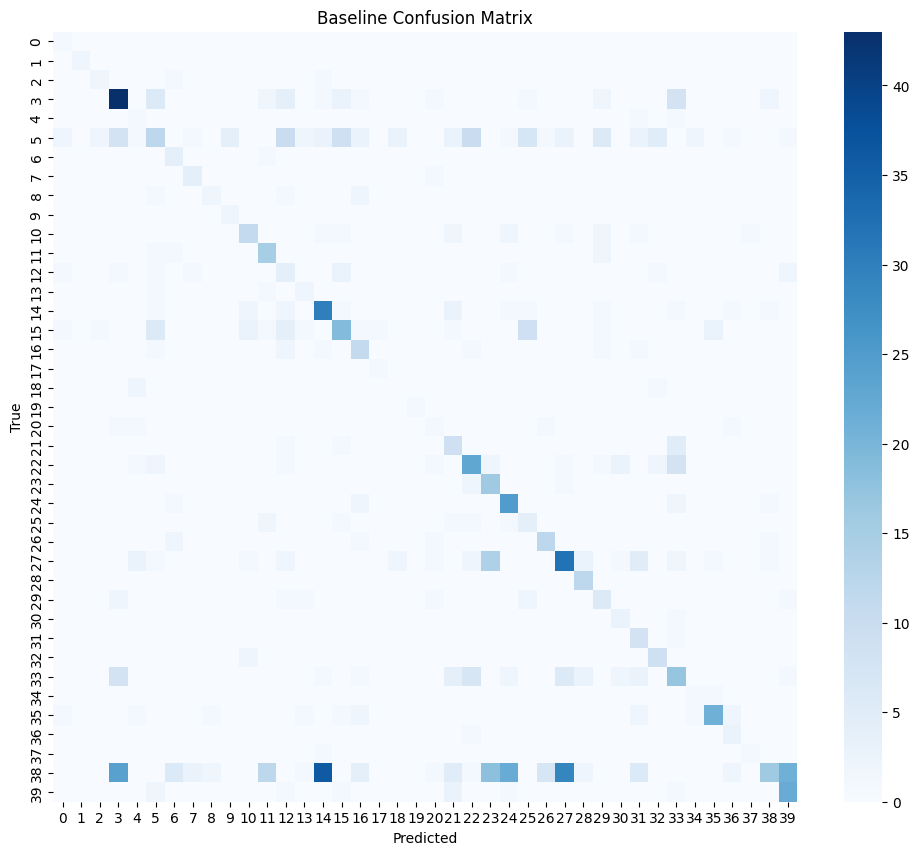

In [23]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Baseline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
errors = pd.DataFrame({'Text': X_val[y_val != y_pred], 'True': y_val[y_val != y_pred], 'Pred': y_pred[y_val != y_pred]})
print("Sample Errors:\n", errors.head(5))

Sample Errors:
                                                    Text  \
4822  duplex ultrasound legsright leg duplex imaging...   
1520  exam three views right footreason exam right f...   
4359  history present illness goes back yesterday pa...   
1166  preoperative diagnosis bladder lesions history...   
1577  exammri left knee without contrastclinicalthis...   

                             True                     Pred  
4822   Cardiovascular / Pulmonary                Radiology  
1520                    Radiology                 Podiatry  
4359   Consult - History and Phy.   Emergency Room Reports  
1166                      Surgery                  Urology  
1577                    Radiology               Orthopedic  


**FINE-TUNING BIOBERT MODEL**

In [25]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [26]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [27]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train_enc})
val_df = pd.DataFrame({'text': X_val, 'label': y_val_enc})
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [28]:
model_name = 'dmis-lab/biobert-base-cased-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [29]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

In [30]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/994 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [33]:
training_args = TrainingArguments(
    output_dir='./biobert_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=True
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1_macro}

In [35]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.class_weights = class_weights

In [36]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anjurishi141 (anjurishi141-nitk) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.124861,0.308853,0.162054
2,3.549100,1.600922,0.611670,0.486073
3,2.326000,1.230245,0.687123,0.600291
4,1.313600,1.121577,0.689135,0.653801
5,0.967600,1.106459,0.688129,0.653952


TrainOutput(global_step=2485, training_loss=1.7958339883048289, metrics={'train_runtime': 728.4671, 'train_samples_per_second': 27.263, 'train_steps_per_second': 3.411, 'total_flos': 5227168391331840.0, 'train_loss': 1.7958339883048289, 'epoch': 5.0})

In [37]:
results = trainer.evaluate()
print("BioBERT Fine-Tuned Results:", results)
predictions = trainer.predict(val_dataset)
y_pred_enc = predictions.predictions.argmax(-1)
y_pred = le.inverse_transform(y_pred_enc)

BioBERT Fine-Tuned Results: {'eval_loss': 1.1064586639404297, 'eval_accuracy': 0.6881287726358148, 'eval_f1': 0.6539522851553755, 'eval_runtime': 8.0276, 'eval_samples_per_second': 123.823, 'eval_steps_per_second': 15.571, 'epoch': 5.0}


In [38]:
acc_biobert = accuracy_score(y_val_enc, y_pred_enc)
f1_biobert = f1_score(y_val_enc, y_pred_enc, average='macro')
print(f"BioBERT Accuracy: {acc_biobert:.4f}, Macro F1: {f1_biobert:.4f}")
print(classification_report(y_val, y_pred))

BioBERT Accuracy: 0.6881, Macro F1: 0.6540
                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       1.00      0.50      0.67         2
                    Bariatrics       0.75      0.75      0.75         4
    Cardiovascular / Pulmonary       0.63      0.82      0.71        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.58      0.38      0.46       103
    Cosmetic / Plastic Surgery       0.40      0.40      0.40         5
                     Dentistry       1.00      0.80      0.89         5
                   Dermatology       0.83      0.83      0.83         6
          Diets and Nutritions       1.00      1.00      1.00         2
             Discharge Summary       0.78      0.82      0.80        22
          ENT - Otolaryngology       0.76      0.84      0.80        19
        Emergency Ro

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


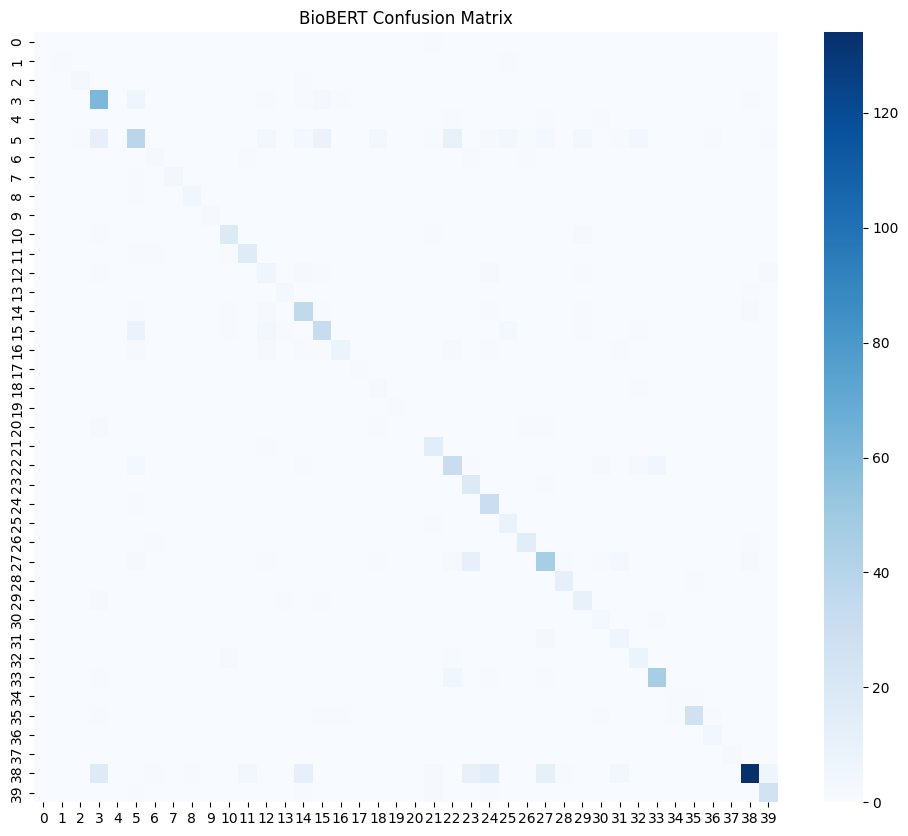

In [39]:
cm_biobert = confusion_matrix(y_val_enc, y_pred_enc)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_biobert, annot=False, cmap='Blues')
plt.title('BioBERT Confusion Matrix')
plt.show()

In [40]:
errors = pd.DataFrame({'Text': X_val[y_val != y_pred].values[:5], 'True': y_val[y_val != y_pred].values[:5], 'Pred': y_pred[y_val != y_pred][:5]})
print("Sample Errors:\n", errors)

Sample Errors:
                                                 Text  \
0  history present illness goes back yesterday pa...   
1  cc weaknesshx yo rhm good health began experie...   
2  preoperative diagnoses weeks days intrauterine...   
3  exam diagnostic cerebral angiogram transcathet...   
4  history present illness yearold male previous ...   

                          True                         Pred  
0   Consult - History and Phy.             General Medicine  
1                    Radiology                    Neurology  
2                      Surgery      Obstetrics / Gynecology  
3                    Neurology                    Radiology  
4   Cardiovascular / Pulmonary   Consult - History and Phy.  


**INCORPORATION OF LANGUAGE MODEL**

EXTERNAL INCORPORATION OF LM

In [53]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import requests
import pandas as pd
import time
from tqdm import tqdm

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)

api_token = ""
api_url = "https://api-inference.huggingface.co/models/facebook/bart-large-mnli"
headers = {"Authorization": f"Bearer {api_token}"}

candidate_labels = list(le.classes_)[:10]
print(f"Number of candidate labels: {len(candidate_labels)}")

def query_external_lm(text, candidate_labels, retries=3, delay=5, timeout=60):
    payload = {
        "inputs": text,
        "parameters": {"candidate_labels": candidate_labels},
        "options": {"wait_for_model": True}
    }
    for attempt in range(retries):
        try:
            response = requests.post(api_url, headers=headers, json=payload, timeout=timeout)
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, dict) and 'scores' in result:
                    score_dict = dict(zip(result.get('labels', candidate_labels), result['scores']))
                    ordered_scores = [score_dict.get(label, 0.0) for label in candidate_labels]
                    return ordered_scores
                else:
                    print(f"Unexpected response format: {result}")
                    return [0.0] * len(candidate_labels)
            else:
                print(f"API Error: {response.status_code} - {response.text}")
                if attempt < retries - 1:
                    time.sleep(delay)
                    continue
                return [0.0] * len(candidate_labels)
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
                continue
            return [0.0] * len(candidate_labels)
    return [0.0] * len(candidate_labels)

def get_external_scores(texts, batch_size=5, max_samples=None):
    scores_list = []
    texts_to_process = texts[:max_samples] if max_samples else texts
    print(f"Processing {len(texts_to_process)} texts...")

    for i in tqdm(range(0, len(texts_to_process), batch_size), desc="Querying API"):
        batch_texts = texts_to_process[i:i+batch_size]
        batch_scores = [query_external_lm(text, candidate_labels) for text in batch_texts]
        scores_list.extend(batch_scores)
        time.sleep(2)
    return np.array(scores_list)

max_samples = 100
logger.info("Extracting external scores for X_val subset...")
external_scores = get_external_scores(X_val, batch_size=5, max_samples=max_samples)
logger.info(f"External scores shape: {external_scores.shape}")

if external_scores.size > 0:
    clf_external = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    clf_external.fit(external_scores, y_val_enc[:len(external_scores)])
    y_pred_external_clf = clf_external.predict(external_scores)
    acc_external_clf = accuracy_score(y_val_enc[:len(external_scores)], y_pred_external_clf)
    f1_external_clf = f1_score(y_val_enc[:len(external_scores)], y_pred_external_clf, average='macro')
    print(f"External LM Scores as Features - Accuracy: {acc_external_clf:.4f}, Macro F1: {f1_external_clf:.4f}")
    print("External LM Scores Classification Report:\n",
          classification_report(y_val[:len(external_scores)], le.inverse_transform(y_pred_external_clf), zero_division=0))
else:
    print("No external scores obtained, proceeding with internal model only.")

INTERNAL INCORPORATION OF LM

In [41]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import requests
import pandas as pd

In [42]:
df['features_raw'] = df['transcription'].fillna('') + ' ' + df['keywords'].fillna('')
X_raw = df['features_raw']
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_raw, df['medical_specialty'],
                                                          test_size=0.2, random_state=42, stratify=df['medical_specialty'])
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

print("X_train_raw shape:", X_train_raw.shape, "y_train shape:", y_train.shape)
print("X_val_raw shape:", X_val_raw.shape, "y_val shape:", y_val.shape)

X_train_raw shape: (3972,) y_train shape: (3972,)
X_val_raw shape: (994,) y_val shape: (994,)


In [43]:
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)

X_train shape: (3972,) y_train shape: (3972,)
X_val shape: (994,) y_val shape: (994,)


In [44]:
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

Internal LM (BioBERT Embeddings + XGBoost) - Accuracy: 0.1137, Macro F1: 0.0868
Internal LM Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       1.00      0.50      0.67         2
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.21      0.23      0.22        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.08      0.08      0.08       103
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                     Dentistry       0.00      0.00      0.00         5
                   Dermatology       0.00      0.00      0.00         6
          Diets and Nutritions       0.00      0.00      0.00         2
             Discharge Summary       0.21      0.14      0.17        22
          ENT - Oto

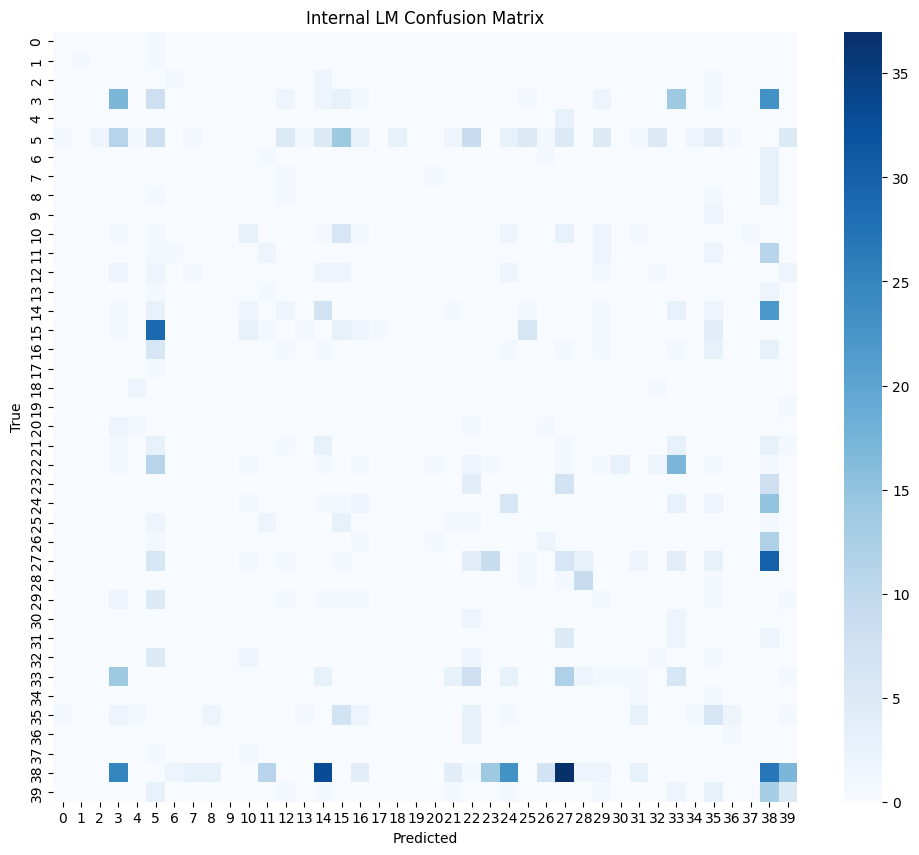

Sample Errors (Internal LM):
                                                 Text  \
0  DUPLEX ULTRASOUND OF LEGS,RIGHT LEG:,  Duplex ...   
1  EXAM:  ,Three views of the right foot.,REASON ...   
2  CC:, Seizures.,HX: ,The patient was initially ...   
3  REASON FOR VISIT: , Followup of laparoscopic f...   
4  HISTORY OF PRESENT ILLNESS: , Goes back to yes...   

                          True                            Pred  
0   Cardiovascular / Pulmonary                       Radiology  
1                    Radiology                      Orthopedic  
2                    Neurology                       Radiology  
3        Pediatrics - Neonatal   SOAP / Chart / Progress Notes  
4   Consult - History and Phy.                General Medicine  


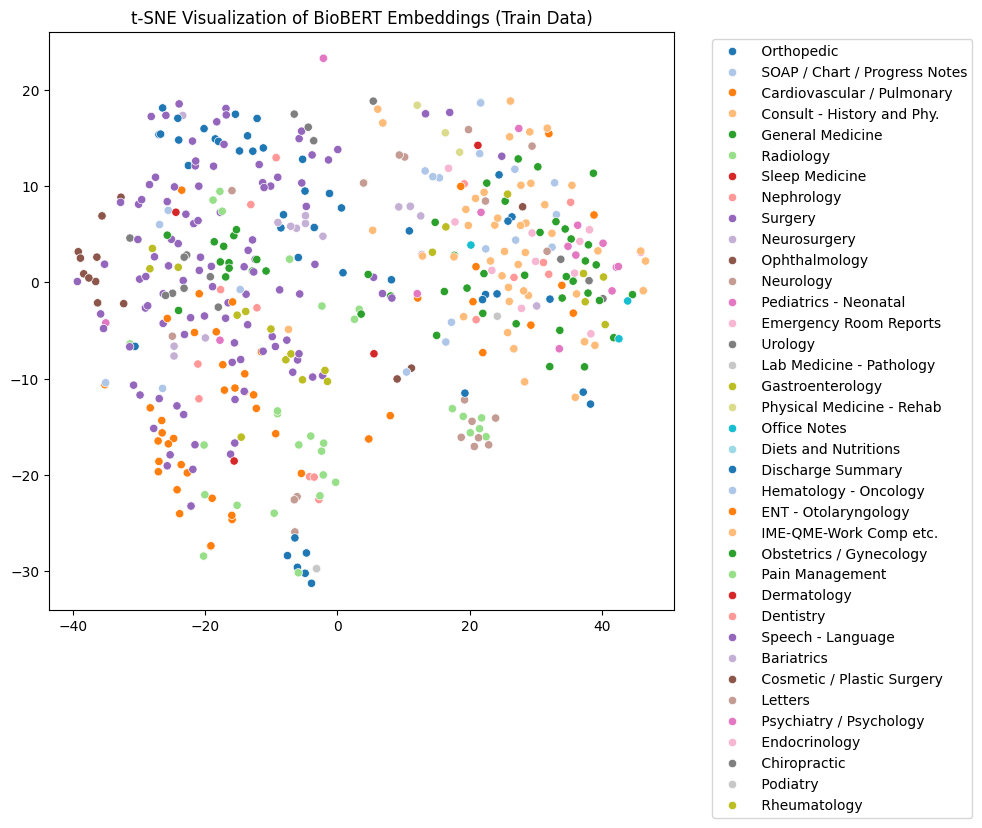

In [45]:
model_name = 'dmis-lab/biobert-base-cased-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def extract_embeddings(texts, batch_size=16, pooling='mean'):
    embeddings = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        if pooling == 'mean':
            attention_mask = inputs['attention_mask'].unsqueeze(-1)
            masked_embeddings = outputs.last_hidden_state * attention_mask
            batch_embeddings = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1)
        else:
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings.cpu().numpy())
    return np.vstack(embeddings)

X_train_emb = extract_embeddings(X_train_raw, batch_size=16, pooling='mean')
X_val_emb = extract_embeddings(X_val_raw, batch_size=16, pooling='mean')

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_emb_resampled, y_train_enc_resampled = smote.fit_resample(X_train_emb, y_train_enc)

clf_internal = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                            objective='multi:softmax', eval_metric='mlogloss', random_state=42)
clf_internal.fit(X_train_emb_resampled, y_train_enc_resampled)

y_pred_internal = clf_internal.predict(X_val_emb)
acc_internal = accuracy_score(y_val_enc, y_pred_internal)
f1_internal = f1_score(y_val_enc, y_pred_internal, average='macro')
print(f"Internal LM (BioBERT Embeddings + XGBoost) - Accuracy: {acc_internal:.4f}, Macro F1: {f1_internal:.4f}")
print("Internal LM Classification Report:\n",
      classification_report(y_val, le.inverse_transform(y_pred_internal), zero_division=0))

cm_internal = confusion_matrix(y_val_enc, y_pred_internal)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_internal, annot=False, cmap='Blues')
plt.title('Internal LM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

errors_internal = pd.DataFrame({
    'Text': X_val_raw[y_val != le.inverse_transform(y_pred_internal)].values[:5],
    'True': y_val[y_val != le.inverse_transform(y_pred_internal)].values[:5],
    'Pred': le.inverse_transform(y_pred_internal)[y_val != le.inverse_transform(y_pred_internal)][:5]
})
print("Sample Errors (Internal LM):\n", errors_internal)

tsne = TSNE(n_components=2, random_state=42)
X_train_emb_2d = tsne.fit_transform(X_train_emb[:500])
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_emb_2d[:, 0], y=X_train_emb_2d[:, 1], hue=le.inverse_transform(y_train_enc[:500]),
                palette='tab20', legend='full')
plt.title('t-SNE Visualization of BioBERT Embeddings (Train Data)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**EDA ON TRAIN TEST RESULTS**

In [61]:
data = {
    'Model': ['Baseline', 'Fine-Tuned BioBERT', 'Internal (XGBoost)'],
    'Train_Accuracy': [0.45,0.69,  0.52],
    'Val_Accuracy': [ 0.41,0.65, 0.52],
    'Train_Macro_F1': [0.43,0.65,  0.56],
}
results_df = pd.DataFrame(data)

train_lengths = X_train.apply(lambda x: len(x.split()))
train_class_dist = y_train.value_counts(normalize=True)

print("Results DataFrame:\n", results_df)
print("\nTrain Data Lengths Summary:\n", train_lengths.describe())
print("\nTrain Class Distribution (Top 5):\n", train_class_dist.head())

Results DataFrame:
                 Model  Train_Accuracy  Val_Accuracy  Train_Macro_F1
0            Baseline            0.45          0.41            0.43
1  Fine-Tuned BioBERT            0.69          0.65            0.65
2  Internal (XGBoost)            0.52          0.52            0.56

Train Data Lengths Summary:
 count    3972.000000
mean      281.756546
std       169.317186
min         2.000000
25%       160.000000
50%       248.000000
75%       367.000000
max      1628.000000
Name: features, dtype: float64

Train Class Distribution (Top 5):
 medical_specialty
Surgery                       0.219033
Consult - History and Phy.    0.103978
Cardiovascular / Pulmonary    0.074773
Orthopedic                    0.071501
Radiology                     0.054884
Name: proportion, dtype: float64


/tmp/ipython-input-3076333015.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Val_Accuracy', data=results_df, palette='viridis')


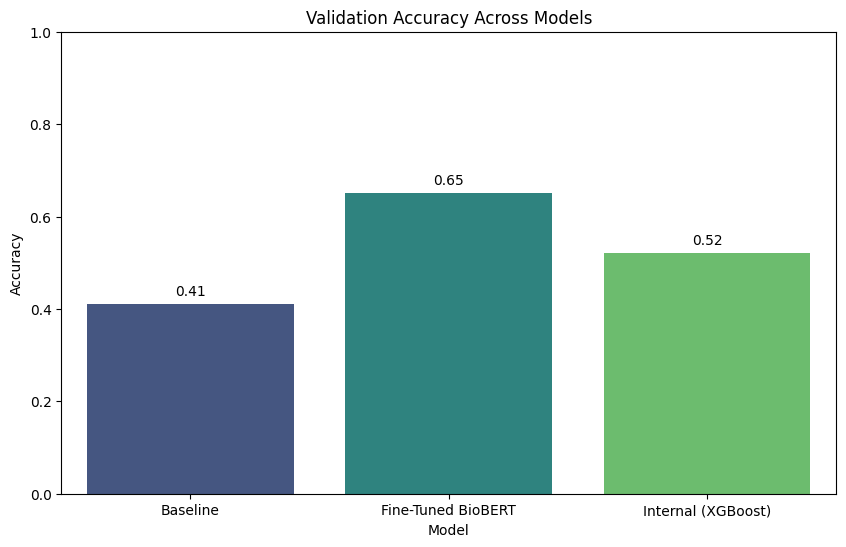

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Val_Accuracy', data=results_df, palette='viridis')
plt.title('Validation Accuracy Across Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
for i, v in enumerate(results_df['Val_Accuracy']):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()

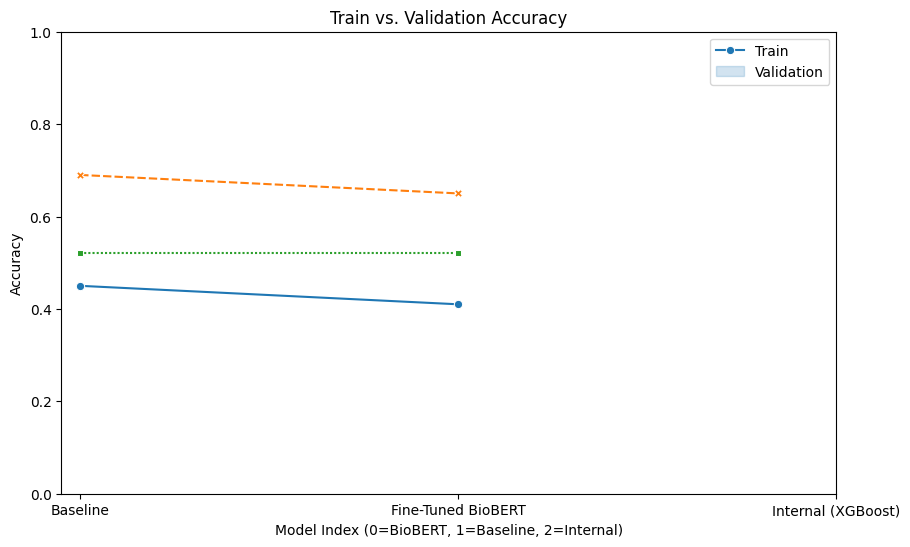

In [65]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df[['Train_Accuracy', 'Val_Accuracy']].T, markers=True)
plt.title('Train vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model Index (0=BioBERT, 1=Baseline, 2=Internal)')
plt.legend(['Train', 'Validation'])
plt.xticks([0, 1, 2], results_df['Model'])
plt.ylim(0, 1)
plt.show()